In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import os

In [71]:
root_dir1 = '/mnt/nfs/dhasade/optml/logs/fedavg/synthetic/1000_1000_lr0.2/r1'
root_dir2 = '/mnt/nfs/dhasade/optml/logs/fedavg/synthetic/1000_1000_lr0.2/r2'

In [72]:
alg1, alg2 = 'iid', 'niid'

In [73]:
n = 50

In [74]:
train_losses = {}
train_accuracies = {}
train_loss_indexes = {}
test_losses = {}
test_accuracies = {}
test_loss_indexes = {}

In [75]:
for alg, root_dir in zip([alg1, alg2], [root_dir1, root_dir2]):
    train_file = os.path.join(root_dir, 'train.csv')
    test_file = os.path.join(root_dir, 'test.csv')

    df = pd.read_csv(train_file)
    train_losses[alg] = df['train_losses'][:n]
    train_accuracies[alg] = df['train_accuracies'][:n]
    train_loss_indexes[alg] = df['train_index'][:n]

    df1 = pd.read_csv(test_file)
    test_losses[alg] = df1['test_losses'][:n]
    test_accuracies[alg] = df1['test_accuracies'][:n]
    test_loss_indexes[alg] = df1['test_index'][:n]

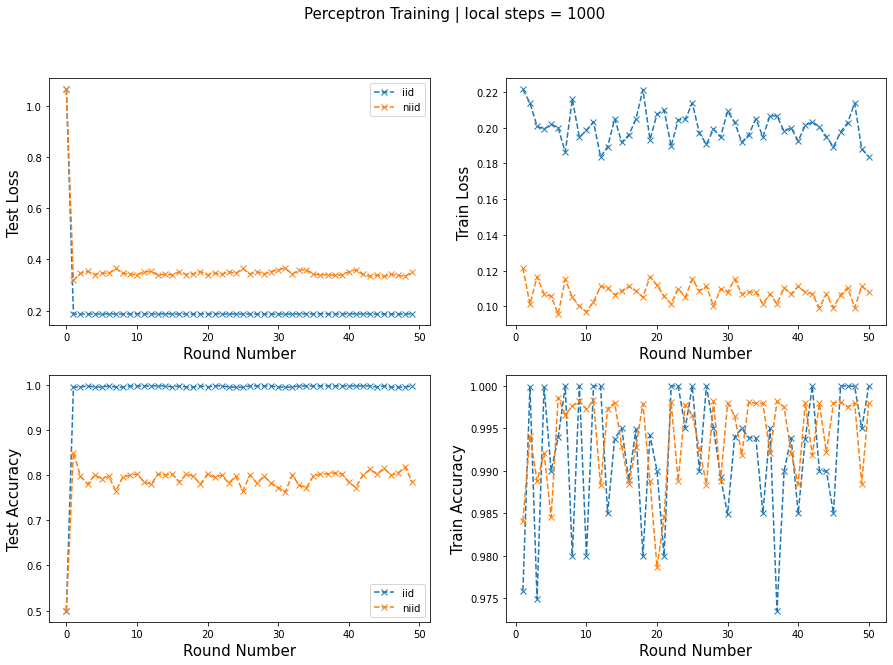

In [77]:
fig, ((axs1, axs2), (axs3, axs4)) = plt.subplots(2, 2, figsize=(15, 10))

for alg in [alg1, alg2]:
    axs1.plot(test_loss_indexes[alg], test_losses[alg], 'x--', label=alg)

    axs2.plot(train_loss_indexes[alg], train_losses[alg], 'x--', label=alg)

    axs3.plot(test_loss_indexes[alg], test_accuracies[alg], 'x--', label=alg)
        
    axs4.plot(train_loss_indexes[alg], train_accuracies[alg], 'x--', label=alg)    

axs1.legend()
axs1.set_ylabel('Test Loss', fontsize=15)
axs1.set_xlabel('Round Number', fontsize=15)
# axs1.tick_params(axis='both', labelsize=12)
# axs1.set_ylim(0.1, 0.6)

axs2.set_ylabel('Train Loss', fontsize=15)
axs2.set_xlabel('Round Number', fontsize=15)
# axs2.tick_params(axis='both', labelsize=12)

axs3.legend()
axs3.set_ylabel('Test Accuracy', fontsize=15)
axs3.set_xlabel('Round Number', fontsize=15)

axs4.set_ylabel('Train Accuracy', fontsize=15)
axs4.set_xlabel('Round Number', fontsize=15)

# plt.legend()
fig.suptitle('Perceptron Training | local steps = 1000', fontsize=15)
# plt.savefig('../logs/figures/tau_1000_m_2.jpg', dpi=300)

### Plotting data points

In [13]:
import random
import json
import numpy as np

In [14]:
train_file = '/mnt/nfs/dhasade/optml/data/synthetic/train/train.json'
test_file = '/mnt/nfs/dhasade/optml/data/synthetic/test/test.json'

In [15]:
with open(train_file) as f:
    train_data = json.load(f)

In [16]:
with open(test_file) as f:
    test_data = json.load(f)

In [17]:
outlier_user = train_data['users'][-1]
normal_user = train_data['users'][0]

In [18]:
outlier_data = train_data['user_data'][outlier_user]
normal_data = train_data['user_data'][normal_user]

In [19]:
xs2, ys2 = outlier_data['x'], outlier_data['y']
xs1, ys1 = normal_data['x'], normal_data['y']

In [20]:
indices = random.choices(range(0, 100), k=50)

In [21]:
xs1_subsampled = np.array([xs1[indice] for indice in indices])
ys1_subsampled = np.array([ys1[indice] for indice in indices])
xs2_subsampled = np.array([xs2[indice] for indice in indices])
ys2_subsampled = np.array([ys2[indice] for indice in indices])

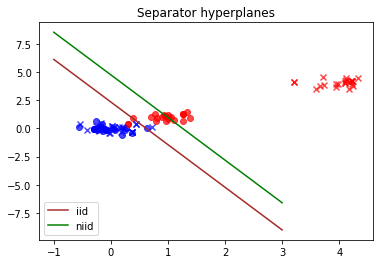

In [82]:
for x, y, label in zip(xs1_subsampled[:,0], xs1_subsampled[:, 1], ys1_subsampled):
    plt.scatter(x, y, color= 'red' if(label == 1.0) else 'blue', alpha=0.7)

for x, y, label in zip(xs2_subsampled[:,0], xs2_subsampled[:, 1], ys2_subsampled):
    plt.scatter(x, y, color= 'red' if(label == 1.0) else 'blue', marker='x', alpha=0.7)

plt.plot(lxs1, lys1, color='brown', label='iid')
plt.plot(lxs2, lys2, color='green', label = 'niid')
plt.legend(loc="lower left")
plt.title('Separator hyperplanes')
# plt.savefig('../logs/figures/tau_1000_m_2_separator.jpg', dpi=300)

### Loading trained model parameters

In [22]:
from models import get_perceptron
import tensorflow as tf

In [23]:
keras_model = get_perceptron()
keras_model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.0)]  
        )

In [78]:
trained_model_path1 = os.path.join(root_dir1, 'trained_model')
trained_model_path2 = os.path.join(root_dir2, 'trained_model')

In [79]:
keras_model.load_weights(trained_model_path1)
theta = keras_model.variables[0].numpy()
bias = keras_model.variables[1].numpy()[0]
theta1 = theta[0][0]; theta2 = theta[1][0]
print(theta1, theta2, bias)
lxs1 = np.linspace(-1.0, 3.0, 100)
lys1 = [-(theta1*x+bias)/theta2 for x in lxs1]

2.700213 0.7134238 -1.6711622


In [80]:
keras_model.load_weights(trained_model_path2)
theta = keras_model.variables[0].numpy()
bias = keras_model.variables[1].numpy()[0]
theta1 = theta[0][0]; theta2 = theta[1][0]
print(theta1, theta2, bias)
lxs2 = np.linspace(-1.0, 3.0, 100)
lys2 = [-(theta1*x+bias)/theta2 for x in lxs2]

2.700213 0.7134238 -3.391392


### Plotting impact of heteroegeneity with varying client local steps

In [84]:
local_steps = [50, 300, 1000, 3000]
alg1 = 'iid'; alg2 = 'niid'

In [85]:
train_losses = {}
train_accuracies = {}
train_loss_indexes = {}
test_losses = {}
test_accuracies = {}
test_loss_indexes = {}

In [86]:
for local_step in local_steps:

    train_losses[local_step] = {}
    train_accuracies[local_step] = {}
    train_loss_indexes[local_step] = {}
    test_losses[local_step] = {}
    test_accuracies[local_step] = {}
    test_loss_indexes[local_step] = {}
    
    file_path = f'/mnt/nfs/dhasade/optml/logs/fedavg/synthetic/{local_step}_{local_step}_lr0.2'
    iid_run = os.path.join(file_path, 'r1')
    niid_run = os.path.join(file_path, 'r2')
    
    for alg, root_dir in zip([alg1, alg2], [iid_run, niid_run]):
        train_file = os.path.join(root_dir, 'train.csv')
        test_file = os.path.join(root_dir, 'test.csv')

        df = pd.read_csv(train_file)
        train_losses[local_step][alg] = df['train_losses'][:n]
        train_accuracies[local_step][alg] = df['train_accuracies'][:n]
        train_loss_indexes[local_step][alg] = df['train_index'][:n]

        df1 = pd.read_csv(test_file)
        test_losses[local_step][alg] = df1['test_losses'][:n]
        test_accuracies[local_step][alg] = df1['test_accuracies'][:n]
        test_loss_indexes[local_step][alg] = df1['test_index'][:n]

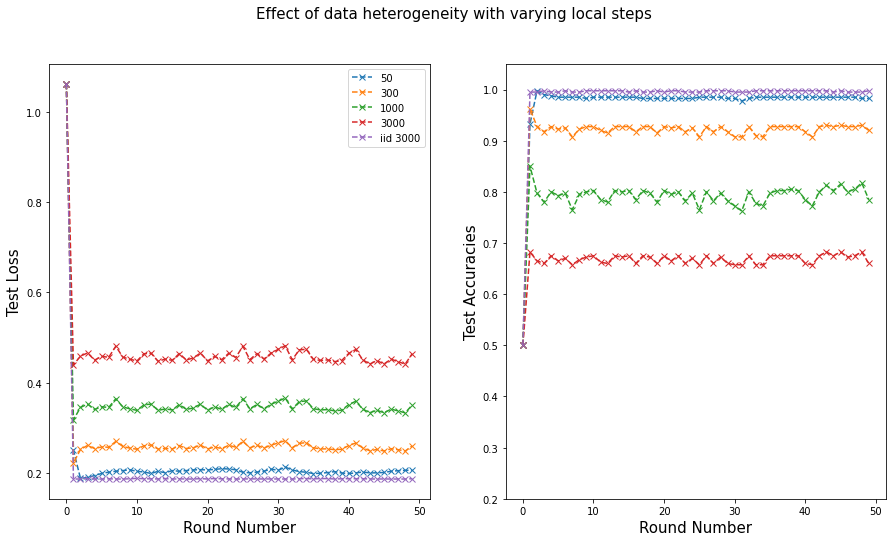

In [100]:
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(15, 8))

for local_step in local_steps:
    
    axs1.plot(test_loss_indexes[local_step][alg2], test_losses[local_step][alg2], 'x--', label=local_step)    

    axs2.plot(test_loss_indexes[local_step][alg2], test_accuracies[local_step][alg2], 'x--', label=local_step)

axs1.plot(test_loss_indexes[local_step][alg1], test_losses[local_step][alg1], 'x--', label=f'iid {local_step}')    

axs2.plot(test_loss_indexes[local_step][alg1], test_accuracies[local_step][alg1], 'x--', label=f'iid {local_step}')

axs1.legend()
axs1.set_ylabel('Test Loss', fontsize=15)
axs1.set_xlabel('Round Number', fontsize=15)
# axs1.tick_params(axis='both', labelsize=12)
# axs1.set_ylim(0.1, 0.6)

axs2.set_ylabel('Test Accuracies', fontsize=15)
axs2.set_xlabel('Round Number', fontsize=15)
axs2.set_ylim(0.2, 1.05)
# axs2.tick_params(axis='both', labelsize=12)

# plt.legend()
fig.suptitle('Effect of data heterogeneity with varying local steps', fontsize=15)
# plt.savefig('../logs/figures/full_data_htr_learning_curves.jpg', dpi=300)

### Plotting trained weights for varying local steps

In [113]:
local_steps = [50, 300, 1000, 3000]
alg1 = 'iid'; alg2 = 'niid'

In [114]:
keras_model = get_perceptron()
keras_model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.0)]  
        )

In [115]:
lines = {}

In [120]:
for local_step in local_steps:
    lines[local_step] = {}

    file_path = f'/mnt/nfs/dhasade/optml/logs/fedavg/synthetic/{local_step}_{local_step}_lr0.2'
    trained_model_path = os.path.join(file_path, 'r2', 'trained_model')
    keras_model.load_weights(trained_model_path)
    
    theta = keras_model.variables[0].numpy()
    bias = keras_model.variables[1].numpy()[0]
    theta1 = theta[0][0]; theta2 = theta[1][0]
    print(theta1, theta2, bias)
    lxs1 = np.linspace(-1.0, 3.0, 100)
    lys1 = [-(theta1*x+bias)/theta2 for x in lxs1]

    lines[local_step]['xs'] = lxs1
    lines[local_step]['ys'] = lys1

# extra step for 3000-iid data
local_step = 3000
file_path = f'/mnt/nfs/dhasade/optml/logs/fedavg/synthetic/{local_step}_{local_step}_lr0.2'
trained_model_path = os.path.join(file_path, 'r1', 'trained_model')
keras_model.load_weights(trained_model_path)

theta = keras_model.variables[0].numpy()
bias = keras_model.variables[1].numpy()[0]
theta1 = theta[0][0]; theta2 = theta[1][0]
print(theta1, theta2, bias)
lxs1 = np.linspace(-1.0, 3.0, 100)
lys1 = [-(theta1*x+bias)/theta2 for x in lxs1]

xs_iid = lxs1
ys_iid = lys1

2.700213 0.7134238 -2.2653854
2.700213 0.7134238 -2.867508
2.700213 0.7134238 -3.391392
2.700213 0.7134238 -3.8696349
2.700213 0.7134238 -1.670629


In [117]:
train_file = '/mnt/nfs/dhasade/optml/data/synthetic/train/train.json'

with open(train_file) as f:
    train_data = json.load(f)

In [118]:
outlier_user = train_data['users'][-1]
normal_user = train_data['users'][0]

outlier_data = train_data['user_data'][outlier_user]
normal_data = train_data['user_data'][normal_user]

xs2, ys2 = outlier_data['x'], outlier_data['y']
xs1, ys1 = normal_data['x'], normal_data['y']

indices = random.choices(range(0, 100), k=30)

xs1_subsampled = np.array([xs1[indice] for indice in indices])
ys1_subsampled = np.array([ys1[indice] for indice in indices])
xs2_subsampled = np.array([xs2[indice] for indice in indices])
ys2_subsampled = np.array([ys2[indice] for indice in indices])

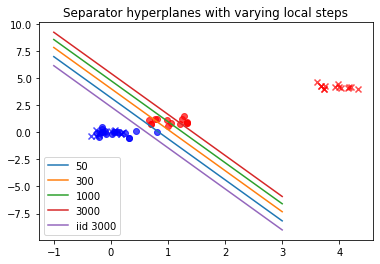

In [123]:
for x, y, label in zip(xs1_subsampled[:,0], xs1_subsampled[:, 1], ys1_subsampled):
    plt.scatter(x, y, color= 'red' if(label == 1.0) else 'blue', alpha=0.7)

for x, y, label in zip(xs2_subsampled[:,0], xs2_subsampled[:, 1], ys2_subsampled):
    plt.scatter(x, y, color= 'red' if(label == 1.0) else 'blue', marker='x', alpha=0.7)

for local_step in local_steps:
    plt.plot(lines[local_step]['xs'], lines[local_step]['ys'], label=local_step)

plt.plot(xs_iid, ys_iid, label='iid 3000')
plt.legend()
plt.title('Separator hyperplanes with varying local steps')
# plt.savefig('../logs/figures/full_data_htr_separator.jpg', dpi=300)